# Mosaicing Tiles and Basic Calculations

This notebook illustrates the use of opening, mosaicing, band math, and masking. 

## Start

In [ ]:
%load_ext watermark

In [2]:
import geowombat as gw
from geowombat.data import rgbn_suba, rgbn_subb

In [3]:
%watermark -a "GeoWombat examples" -d -v -m -p dask,geowombat,numpy,rasterio,xarray -g

GeoWombat examples 2020-03-15 

CPython 3.7.5
IPython 7.12.0

dask 2.11.0
geowombat 1.2.6
numpy 1.18.1
rasterio 1.1.3
xarray 0.15.0

compiler   : GCC 8.3.0
system     : Linux
release    : 4.15.0-88-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 8
interpreter: 64bit
Git hash   : b62c1060763de9c5902082cd01e478b15469ae33


## Opening files

Files are opened lazily using `xarray.open_rasterio` as a backend. This means that the data structure is setup as an `xarray.DataArray` with an underlying `dask` array, but data are not loaded upon opening.

## Image mosaicking
Mosaic the two subsets into a single DataArray. If the images in the mosaic list have the same CRS, no configuration is needed.

In [4]:
with gw.open([rgbn_suba, rgbn_subb],
              band_names=['blue', 'green', 'red', 'nir'],
              mosaic=True,
              bounds_by='union') as ds_mos:
     print(ds_mos)

<xarray.DataArray (band: 4, y: 283, x: 449)>
dask.array<maximum, shape=(4, 283, 449), dtype=uint8, chunksize=(1, 64, 64), chunktype=numpy.ndarray>
Coordinates:
  * band     (band) <U5 'blue' 'green' 'red' 'nir'
  * y        (y) float64 2.05e+06 2.05e+06 2.05e+06 ... 2.049e+06 2.049e+06
  * x        (x) float64 7.929e+05 7.929e+05 7.929e+05 ... 7.952e+05 7.952e+05
Attributes:
    transform:   (5.0, 0.0, 792925.0, 0.0, -5.0, 2050115.0)
    crs:         +init=epsg:32618
    res:         (5.0, 5.0)
    is_tiled:    0
    nodatavals:  (0.0, 0.0, 0.0, 0.0)
    scales:      (1.0, 1.0, 1.0, 1.0)
    offsets:     (0.0, 0.0, 0.0, 0.0)
    resampling:  nearest


## Plotting  

Array plotting `DataArray.plot.imshow()` or `DataArray.gw.imshow()`. The latter is just a wrapper around the former to tidy up the plot axes. Note that only 1- or 3-band arrays can be plotted

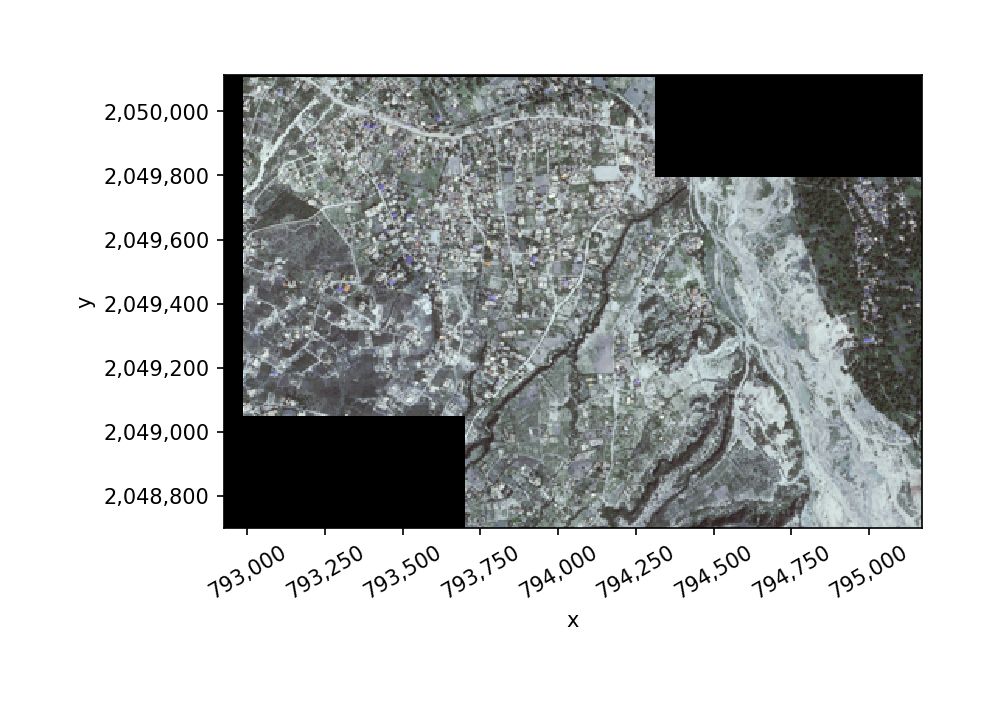

In [5]:
ds_mos.sel(band=['blue', 'green', 'red']).gw.imshow()

## Calculating NDVI

Now let's calculate NDVI. In order to do this we need to update our sensor configuration to take into account the band types and the scale factor for the data.

<xarray.DataArray (band: 1, y: 283, x: 449)>
dask.array<broadcast_to, shape=(1, 283, 449), dtype=float64, chunksize=(1, 64, 64), chunktype=numpy.ndarray>
Coordinates:
  * y        (y) float64 2.05e+06 2.05e+06 2.05e+06 ... 2.049e+06 2.049e+06
  * x        (x) float64 7.929e+05 7.929e+05 7.929e+05 ... 7.952e+05 7.952e+05
  * band     (band) <U4 'ndvi'
Attributes:
    transform:    (5.0, 0.0, 792925.0, 0.0, -5.0, 2050115.0)
    crs:          +init=epsg:32618
    res:          (5.0, 5.0)
    is_tiled:     0
    nodatavals:   None
    scales:       1.0
    offsets:      0.0
    sensor:       bgrn
    resampling:   nearest
    pre-scaling:  0.0001
    vi:           ndvi
    drange:       (-1, 1)


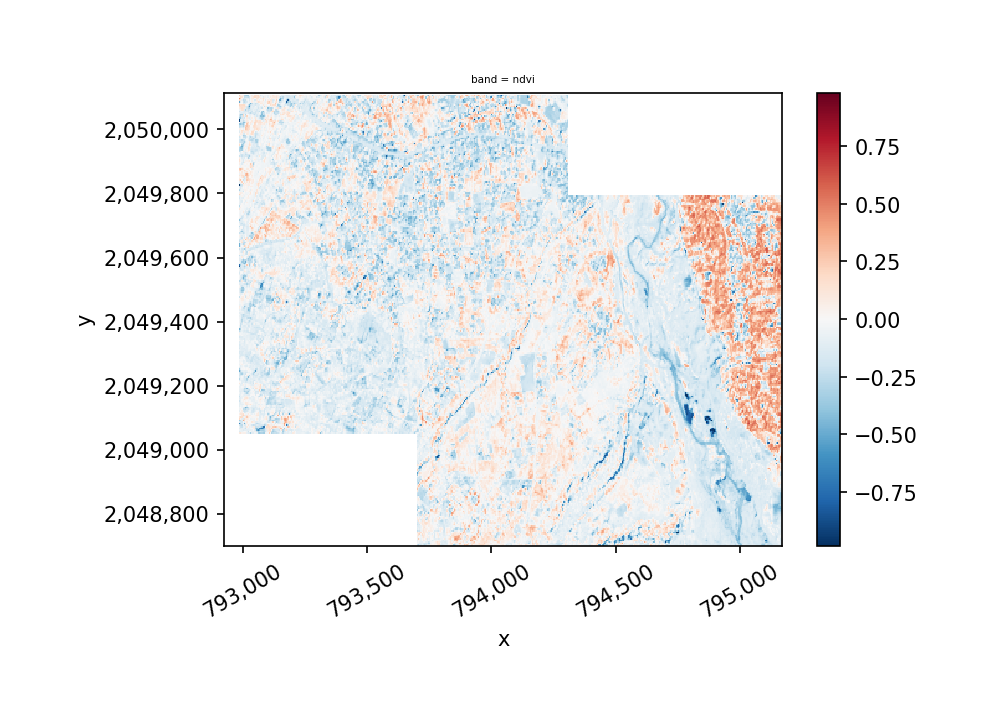

In [6]:
with gw.config.update(sensor='bgrn', scale_factor=0.0001):
    with gw.open([rgbn_suba, rgbn_subb],
          mosaic=True,
          bounds_by='union') as ds_mos:

              # calculate NDVI
              ndvi = ds_mos.gw.ndvi()
              print(ndvi)

ndvi.sel(band='ndvi').gw.imshow() 

## Masking With Another Raster

Geowombat also makes masking out values easy. To set a global mask follow this general proceedure. 

NOTE: Masking can also be done using shapefiles, [see mask](https://geowombat.readthedocs.io/en/latest/api/geowombat.mask.html#geowombat.mask).  

In [7]:
with gw.config.update(sensor='bgrn', scale_factor=0.0001):
    with gw.open([rgbn_suba, rgbn_subb],
              mosaic=True,
              bounds_by='union') as ds_mos:
     print(ds_mos)

<xarray.DataArray (band: 4, y: 283, x: 449)>
dask.array<maximum, shape=(4, 283, 449), dtype=uint8, chunksize=(1, 64, 64), chunktype=numpy.ndarray>
Coordinates:
  * band     (band) <U5 'blue' 'green' 'red' 'nir'
  * y        (y) float64 2.05e+06 2.05e+06 2.05e+06 ... 2.049e+06 2.049e+06
  * x        (x) float64 7.929e+05 7.929e+05 7.929e+05 ... 7.952e+05 7.952e+05
Attributes:
    transform:   (5.0, 0.0, 792925.0, 0.0, -5.0, 2050115.0)
    crs:         +init=epsg:32618
    res:         (5.0, 5.0)
    is_tiled:    0
    nodatavals:  (0.0, 0.0, 0.0, 0.0)
    scales:      (1.0, 1.0, 1.0, 1.0)
    offsets:     (0.0, 0.0, 0.0, 0.0)
    sensor:      blue, green, red, and NIR
    resampling:  nearest


Masking can simply be accomplished with `.where`

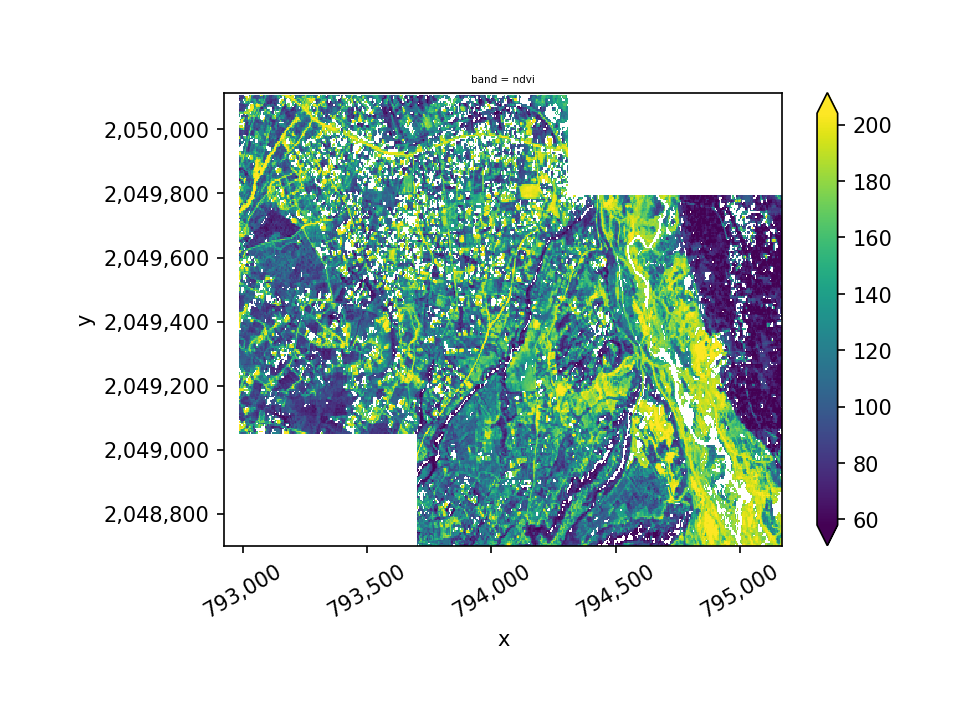

In [8]:
masked = ds_mos.sel(band='blue').where(ndvi >= -0.25)
masked.sel(band='ndvi').gw.imshow(robust=True)

## Storing a mask for later use
We can also create a masking layer that be be concatenated into the dataset for later use. 

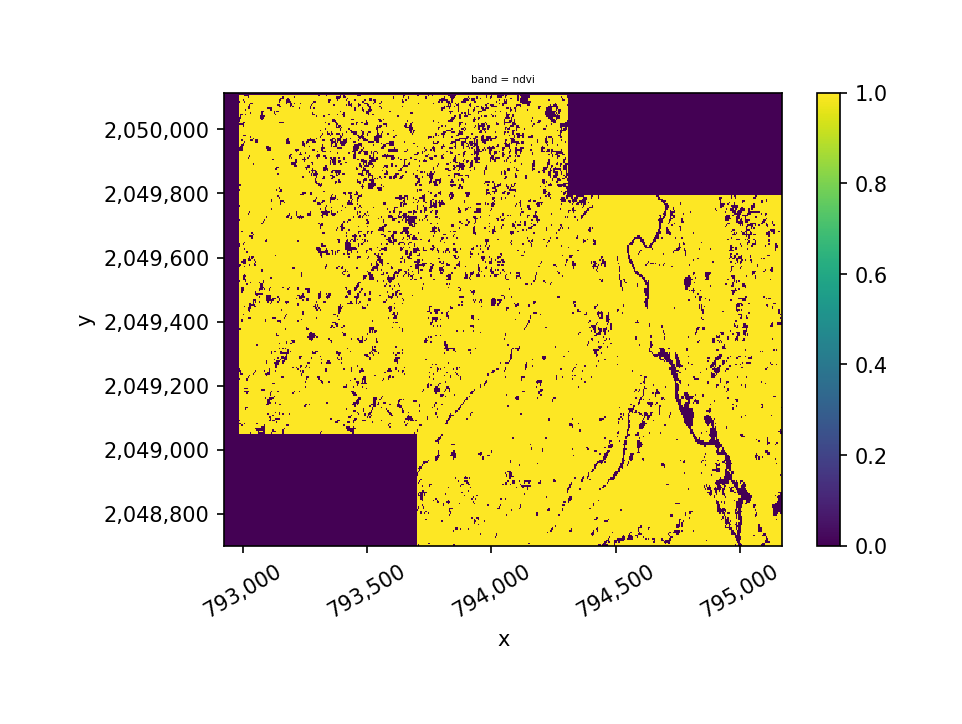

In [9]:
masker =  ndvi >= -0.25
masker.sel(band='ndvi').gw.imshow(robust=True)

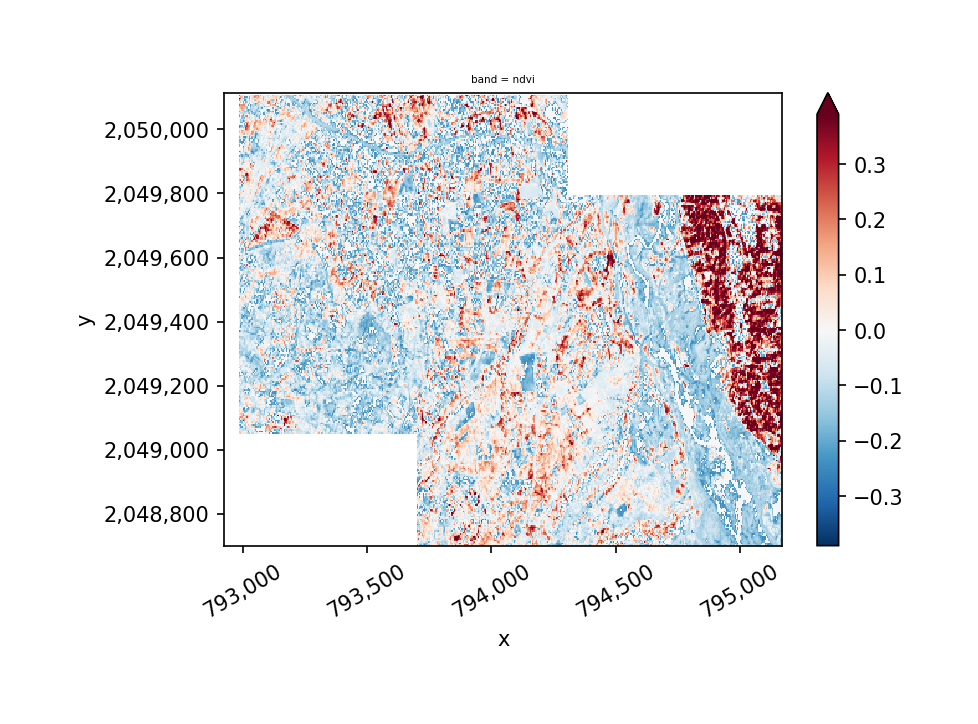

In [10]:
ndvi_mask = ndvi*masker 
ndvi_mask.sel(band='ndvi').gw.imshow(robust=True)

We can keep the mask as a separate array entity, or, if we are using it routinely, there are advantages to adding it as a band in the DataArray:


In [11]:
import xarray as xr
ds_mos_ndvi = xr.concat([ds_mos,masker], dim="band")
ds_mos_ndvi

<xarray.DataArray (band: 5, y: 283, x: 449)>
dask.array<concatenate, shape=(5, 283, 449), dtype=uint8, chunksize=(1, 64, 64), chunktype=numpy.ndarray>
Coordinates:
  * y        (y) float64 2.05e+06 2.05e+06 2.05e+06 ... 2.049e+06 2.049e+06
  * x        (x) float64 7.929e+05 7.929e+05 7.929e+05 ... 7.952e+05 7.952e+05
  * band     (band) object 'blue' 'green' 'red' 'nir' 'ndvi'
Attributes:
    transform:   (5.0, 0.0, 792925.0, 0.0, -5.0, 2050115.0)
    crs:         +init=epsg:32618
    res:         (5.0, 5.0)
    is_tiled:    0
    nodatavals:  (0.0, 0.0, 0.0, 0.0)
    scales:      (1.0, 1.0, 1.0, 1.0)
    offsets:     (0.0, 0.0, 0.0, 0.0)
    sensor:      blue, green, red, and NIR
    resampling:  nearest

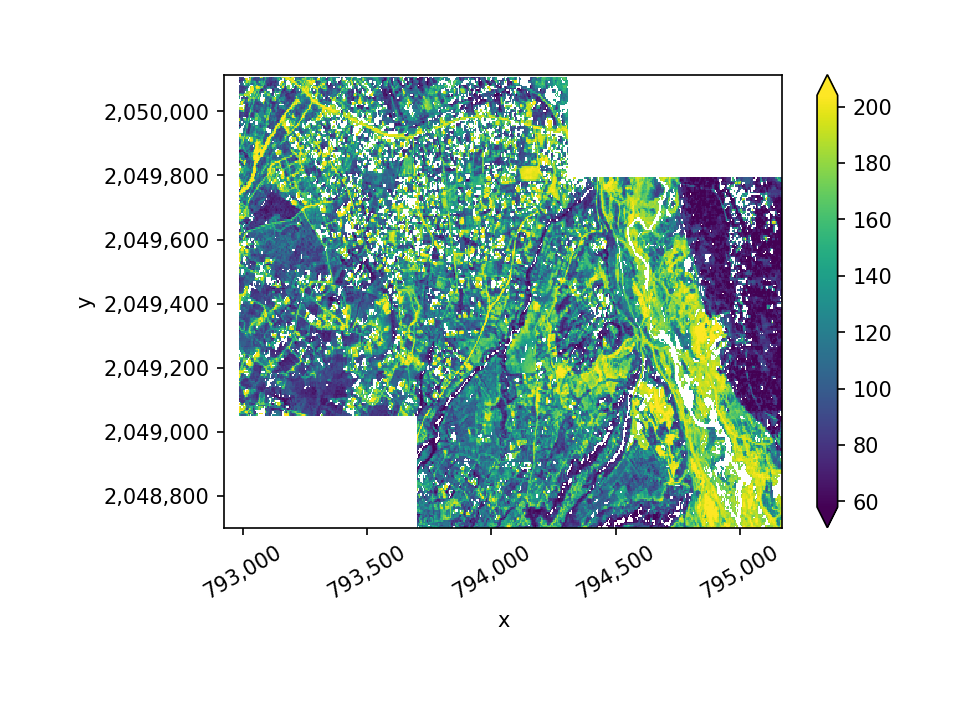

In [12]:
ds_mos_ndvi.sel(band='blue').where(ds_mos_ndvi.sel(band='ndvi') == 1).gw.imshow(robust=True)

We can also apply a mask across multiple bands as follows:

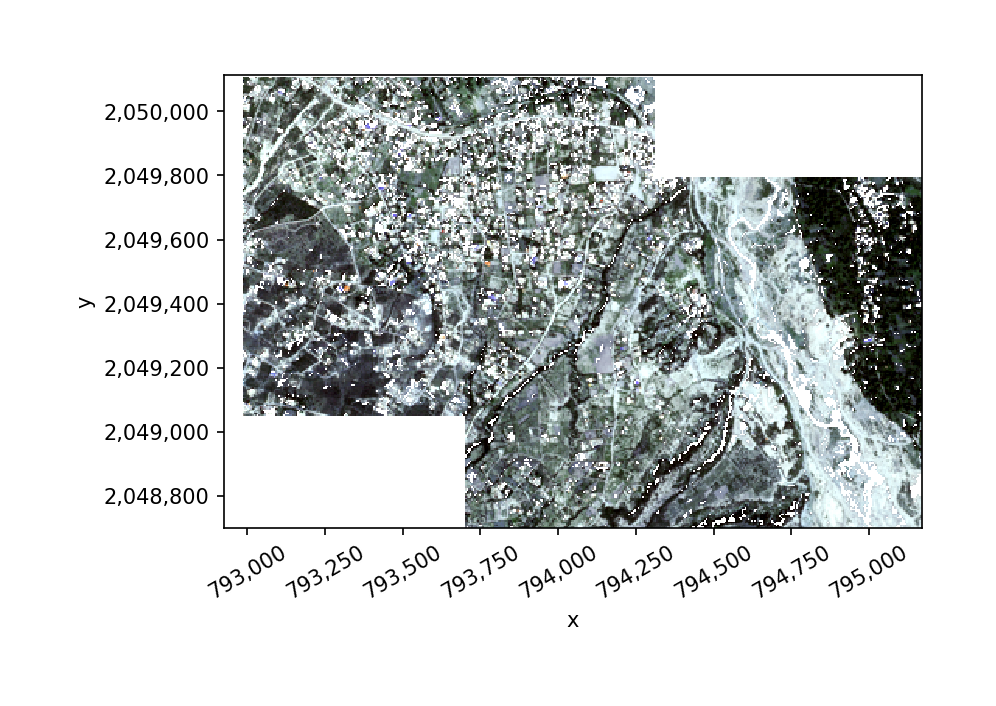

In [13]:
ds_mos_ndvi.sel(band=['blue', 'green', 'red']).where(ds_mos_ndvi.sel(band='ndvi') == 1).gw.imshow(robust=True)